## Pasilla Dataset

### Obtaining the Pasilla dataset

Experimental RNA-seq samples from Brooks et al. (2011): The experiment widely known as pasilla (Brooks et al., 2011) is an ensemble of 6 vs 6 RNA-seq experiment (with NCMI GEO accession numbers GSM461176 to GSM461181) that studies the effect of RNAi knockdown of Pasilla, which is the ortholog in Drosophila melanogaster of NOVA1 and NOVA2 mammallian genes. 

 For Salmon quantification, alignment, terminus grouping, and mmcollapse grouping the same commands found in `Plots_Related_To_Human_Simulated_4x4_Dataset.ipynb` are used.

The reference is obtained from fly-base and family information is downloaded using biomart.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import readBootstraps
from collections import defaultdict

In [6]:
dmel_gene_tr_name = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/reference/dmel/gene_transcript_symbol.tsv',
    sep = '\t',
    names = ['gene_name','gene_symbol','tr_id','tr_name']
)
dmel_gene_family = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/reference/dmel/gene_family.tsv',
    sep = '\t'
)
dmel_info = pd.merge(
    dmel_gene_tr_name,
    dmel_gene_family,
    on = 'gene_name',
    how = 'left'
)
dmel_info.loc[dmel_info.family_name.isna(),'family_name'] = 'noinfo'
t2g = dmel_info[['tr_id','gene_name']].set_index('tr_id')['gene_name'].to_dict()
t2f = dmel_info[['tr_id','family_name']].set_index('tr_id')['family_name'].to_dict()

def build_biological_info_df(gf,t2g,t2f):
    results = []
    group_map = defaultdict(list)
    with open(gf) as fp:
        for line in fp:
            names = line.strip().split(',')
            num_transcripts= 0
            genes_set = set()
            fam_set = set()
            for n in names[1:]:
                group_map[names[0]].append(n)
                if t2f[n] != 'noinfo':
                    num_transcripts += 1
                    genes_set.add(t2g[n])
                    fam_set.add(t2f[n])
            if num_transcripts > 0:   
                results += [[names[0], num_transcripts, len(genes_set), len(fam_set)]]
    df = pd.DataFrame(results, columns=['group_id','num_transcripts','num_genes', 'num_families'])
    return {
        'df': df,
        'groups':group_map
    }

def get_groups(file_name):
    group_map = defaultdict(list)
    mmcollapse_df = pd.read_csv(
        file_name,
        sep = '\t',
        skiprows = 1
    )
    
    import re
    mmcollapse_groups = {}
    group_names = []
    grouped_transcripts_mmcollapse = []
    for t in mmcollapse_df.feature_id.values:
        if ('+' in t) or ('*' in t):
            cands = re.split('\+|\*', t)
            for c in cands:
                group_map[t].append(c)
                mmcollapse_groups[c] = t
                grouped_transcripts_mmcollapse += [c]
            group_names += [t]
        else:
            mmcollapse_groups[t] = t
            
    return {
        'mmcollapse_groups':mmcollapse_groups,
        'grouped_transcripts':grouped_transcripts_mmcollapse,
        'group_names':group_names,
        'group_map' : group_map
    }

In [3]:
def get_group_info_merc():
    group_map = defaultdict(list)
    results_merc = []
    num_of_collapsed = 0
    num_groups = 0
    with open('/mnt/scratch1/hirak/ASE_Analysis/drosophila/mercury_result_new/GSR461176/clusters.txt') as fp:
        for line in fp:
            names = line.strip().split(',')
            num_transcripts= 0
            genes_set = set()
            fam_set = set()
            for n in names[1:]:
                if t2f[n] != 'noinfo':
                    num_transcripts += 1
                    genes_set.add(t2g[n])
                    fam_set.add(t2f[n])
                num_of_collapsed += 1
            num_groups += 1
            if num_transcripts > 0:
                results_merc += [[names[0], num_transcripts, len(genes_set), len(fam_set)]]
                
    df_merc = pd.DataFrame(results_merc, columns=['group_id','num_transcripts','num_genes', 'num_families'])
    return(df_merc, num_of_collapsed, num_groups)

def get_group_info_mmcollapse(mmcollapse_group_info):
    results_mmcollapse = [] 
    num_of_collapsed = 0
    num_groups = 0
    for k,v in mmcollapse_group_info['group_map'].items():
        num_transcripts= 0
        genes_set = set()
        fam_set = set()
        for t in v:
            if t2f[t] != 'noinfo':
                num_transcripts += 1
                genes_set.add(t2g[t])
                fam_set.add(t2f[t])
            num_of_collapsed += 1
        num_groups += 1
        if num_transcripts > 0:
            results_mmcollapse += [[k, num_transcripts, len(genes_set), len(fam_set)]]

    df_mmcollapse = pd.DataFrame(results_mmcollapse, columns=[
        'group_id','num_transcripts','num_genes', 'num_families'])
    return(df_mmcollapse, num_of_collapsed, num_groups)

In [4]:
mmcollapse_group_info = get_groups('/mnt/scratch1/hirak/ASE_Analysis/drosophila/mmcollapse_salmon/GSR461176.collapsed.mmseq')

In [11]:
df_merc, num_merc_collapses, num_merc_groups = get_group_info_merc()

In [12]:
df_mmcollapse, num_mm_collapses, num_mm_groups = get_group_info_mmcollapse(mmcollapse_group_info)

#### Figure 6(a)

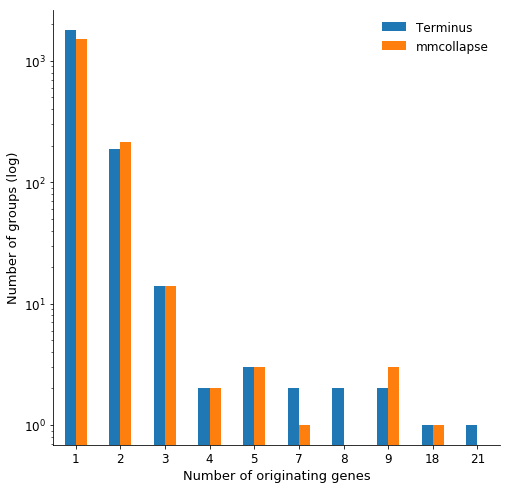

In [13]:
df_joined = pd.DataFrame(df_merc.groupby('num_genes')['group_id'].count()).join(
    pd.DataFrame(df_mmcollapse.groupby('num_genes')['group_id'].count()),
    rsuffix = '_mmcollapse',
)
df_joined.columns = ['Terminus','mmcollapse']
ax = df_joined.plot(kind='bar',figsize=(8,8),rot=0)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.ylabel('Number of groups (log)', fontsize = 13)
plt.xlabel('Number of originating genes', fontsize = 13)
plt.yscale('log')
ax.legend(frameon = False,fontsize=12)
sns.despine()

#### Figure 6(b)

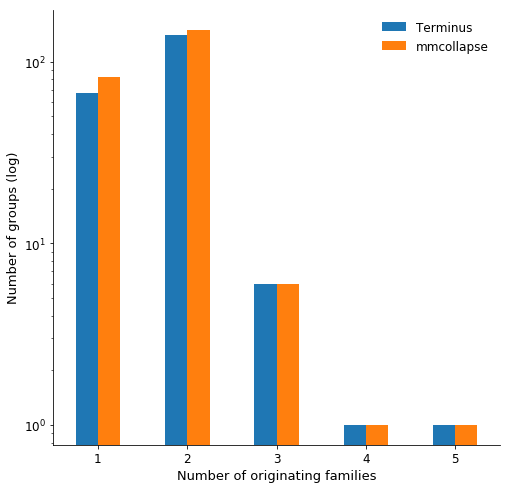

In [14]:
nts = df_merc.loc[
    ~((df_merc.num_genes == 1) & (df_merc.num_families == 1))
]

ntm = df_mmcollapse.loc[
    ~((df_mmcollapse.num_genes == 1) & (df_mmcollapse.num_families == 1))
]

df_joined = pd.DataFrame(nts.groupby('num_families')['group_id'].count()).join(
    pd.DataFrame(ntm.groupby('num_families')['group_id'].count()),
    rsuffix = '_mmcollapse',
)
df_joined.columns = ['Terminus','mmcollapse']
ax = df_joined.plot(kind='bar',figsize=(8,8), rot = 0)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.ylabel('Number of groups (log)',fontsize = 13)
plt.xlabel('Number of originating families',fontsize = 13)
plt.yscale('log')
ax.legend(frameon = False,fontsize=12)
sns.despine()